In [36]:
from matplotlib import pyplot as plt
import platform, os, sys, time
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime
from termcolor import colored, cprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [37]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [38]:
# Load the data from the dsp file: 
path = r'/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials/M016 V5 XZ potential/160524 - M016v5 resonator xz cut.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ===================  =====================
Parameter           Value                  Std
===========  ===================  =====================
a0           -0.7348233452326068  0.0004701768922920603
a1            24638.8342522786      734.8227271324546
a2           12229365732.972181    205184436.07299548
===========  ===================  =====================
f = 14.816 +/- -0.221 GHz


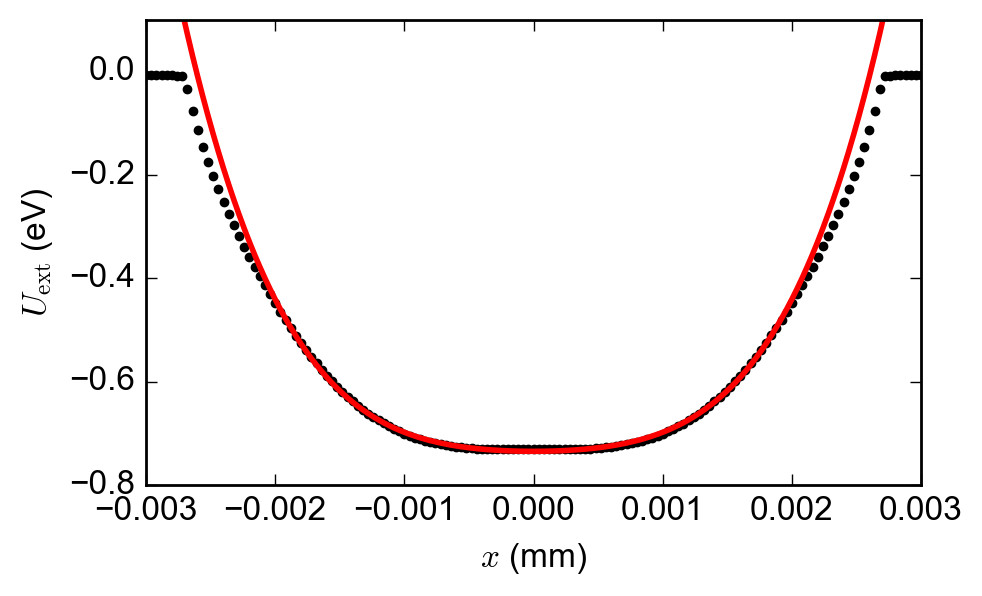

In [39]:
h = 0.78E-3
fitdomain=(-2E-3, 2E-3)

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)

xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=h, clim=(0.00, 1.00), plot_axes='xy', linestyle='None',
                                                     cmap=plt.cm.viridis, plot_data=False, 
                                                     **common.plot_opt("darkorange", msize=6))

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(xinterp[0], -Uinterp[0], '.k')
plt.ylim(-0.8, 0.1)
plt.xlim(-3E-3, 3E-3)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ (mm)")

ax = plt.gca()
ax.set_axis_bgcolor('none')
fr, ferr = kfit.fit_poly(xinterp[0], -Uinterp[0], mode='even', fitparams=[0, 1E4, 1E4], domain=fitdomain)
plt.plot(xinterp[0], kfit.polyfunc_even(xinterp[0], *fr), color='r', lw=2.0)

t = trap_analysis.TrapSolver()
t.get_electron_frequency([fr[0], -fr[1]/1E6], [ferr[0], -ferr[1]/1E6]);

The fit doesn't capture how there's two bumps in the potential, so in the end, I think we should still use the experimental data. This is not very hard, since we can just use the 1D interpolated data. Let us construct the interpolating function now.

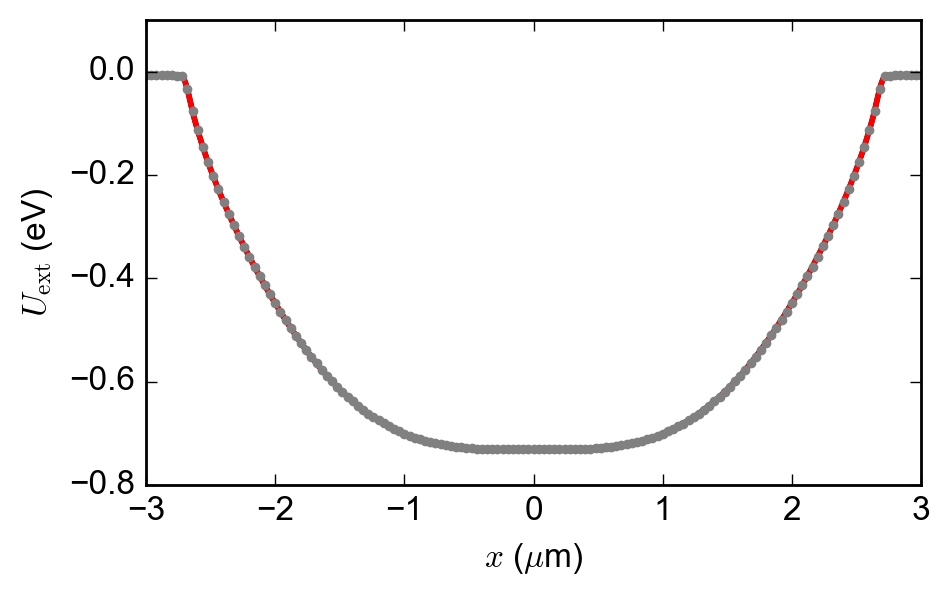

In [40]:
from scipy.interpolate import interp1d, UnivariateSpline
f = interp1d(xinterp[0]*1E-3, -Uinterp[0], kind='cubic')
g = UnivariateSpline(xinterp[0]*1E-3, -Uinterp[0], s=0)

x_test = np.linspace(-3E-6, 3E-6, 1E4)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_test*1E6, f(x_test), '-k', lw=2.0)
plt.plot(x_test*1E6, g(x_test), '-r', lw=2.0)
plt.plot(xinterp[0]*1E3, -Uinterp[0], '.', color='gray')
plt.ylim(-0.8, 0.1)
plt.xlim(-3, 3)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ ($\mu$m)")

Using `UnivariateSpline` we can also easily calculate the derivative in the $x$-direction. Something that is useful for evaluating the derivative.

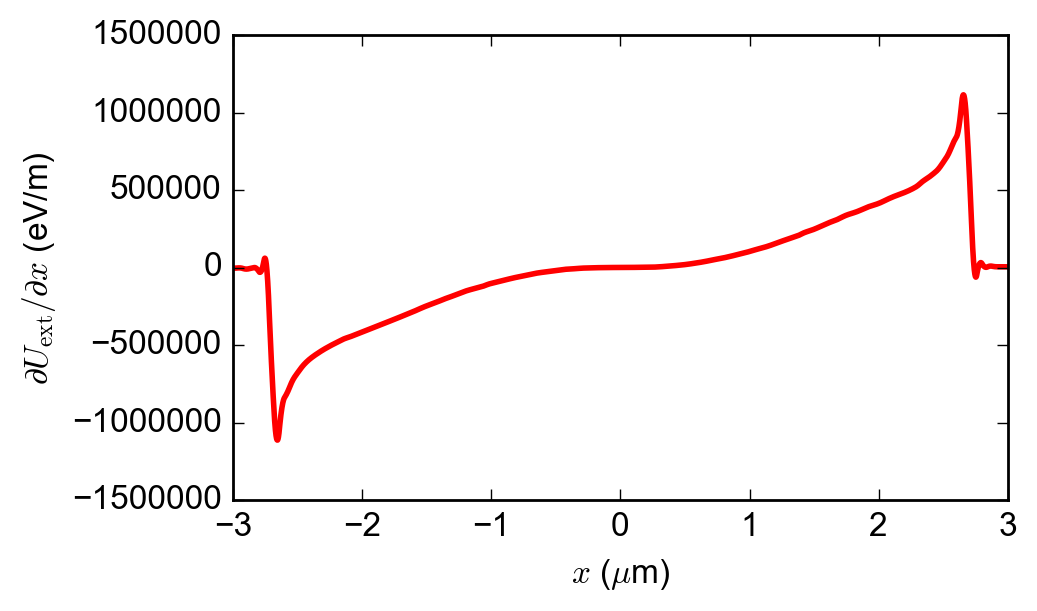

In [41]:
dgdx = g.derivative(n=1)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_test*1E6, dgdx(x_test), '-r', lw=2.0)
#plt.ylim(-0.8, 0.1)
plt.xlim(-3, 3)
plt.ylabel("$\partial U_{\mathrm{ext}} / \partial x$ (eV/m)")
plt.xlabel("$x$ ($\mu$m)")

In [53]:
class ElectrostaticPotential:

    def __init__(self, grid_data, potential_data, spline_order_x=3, smoothing=0):

        self.interpolator = UnivariateSpline(grid_data, potential_data, k=spline_order_x, s=smoothing, ext=3)
        self.derivative = self.interpolator.derivative(n=1)
        self.second_derivative = self.interpolator.derivative(n=2)
        
        # Constants
        self.qe = 1.602E-19
        self.eps0 = 8.85E-12
        
    def map_y_into_domain(self, y, ybounds=(-20E-6, 20E-6)):
        return ybounds[0] + (y-ybounds[0])%(ybounds[1]-ybounds[0])

    def calculate_Rij(self, xi, yi):
        Xi, Yi = np.meshgrid(xi, yi)
        Xj, Yj = Xi.T, Yi.T
        
        Rij_standard = np.sqrt((Xi - Xj) ** 2 + (Yi - Yj) ** 2)
        
        Yi_shifted = Yi.copy()
        Yi_shifted[Yi_shifted>0] -= 40E-6 # Shift entire box length
        Yj_shifted = Yi_shifted.T
        
        Rij_shifted = np.sqrt((Xi - Xj) ** 2 + (Yi_shifted - Yj_shifted) ** 2)
        
        return np.minimum(Rij_standard, Rij_shifted)
    
    def calculate_YiYj(self, xi, yi):
        Xi, Yi = np.meshgrid(xi, yi)
        Xj, Yj = Xi.T, Yi.T
        
        Yi_shifted = Yi.copy()
        Yi_shifted[Yi_shifted>0] -= 40E-6 # Shift entire box length
        Yj_shifted = Yi_shifted.T
        
        Rij_standard = np.sqrt((Xi - Xj) ** 2 + (Yi - Yj) ** 2)
        Rij_shifted = np.sqrt((Xi - Xj) ** 2 + (Yi_shifted - Yj_shifted) ** 2)
        
        YiYj = Yi-Yj
        
        # Use shifted y-coordinate only in this case:
        mask = np.where(Rij_shifted < Rij_standard)[0]
        YiYj[mask] = Yi_shifted[mask] - Yj_shifted[mask]
        
        return YiYj
    
    def V(self, xi, yi):
        return self.interpolator(xi)

    def Velectrostatic(self, xi, yi):
        return self.qe * np.sum(self.V(xi, yi))

    def Vee(self, xi, yi, eps=1E-15):
        yi = self.map_y_into_domain(yi)
        Rij = self.calculate_Rij(xi, yi)
        np.fill_diagonal(Rij, eps)

        return + 1 / 2. * self.qe ** 2 / (4 * np.pi * self.eps0) * 1 / Rij

    def Vtotal(self, r):
        xi, yi = r[::2], r[1::2]
        Vtot = self.Velectrostatic(xi, yi)
        interaction_matrix = self.Vee(xi, yi)
        np.fill_diagonal(interaction_matrix, 0)
        Vtot += np.sum(interaction_matrix)
        return Vtot / self.qe

    def dVdx(self, xi, yi):
        return self.derivative(xi)

    def ddVdx(self, xi, yi):
        return self.second_derivative(xi)

    def dVdy(self, xi, yi):
        return np.zeros(len(xi))

    def ddVdy(self, xi, yi):
        return np.zeros(len(xi))

    def grad_Vee(self, xi, yi, eps=1E-15):
        yi = self.map_y_into_domain(yi)
        Xi, Yi = np.meshgrid(xi, yi)
        Xj, Yj = Xi.T, Yi.T

        Rij = self.calculate_Rij(xi, yi)
        np.fill_diagonal(Rij, eps)

        gradx_matrix = np.zeros(np.shape(Rij))
        grady_matrix = np.zeros(np.shape(Rij))
        gradient = np.zeros(2 * len(xi))

        gradx_matrix = -1 * self.qe ** 2 / (4 * np.pi * self.eps0) * (Xi - Xj) / Rij ** 3
        np.fill_diagonal(gradx_matrix, 0)
        
        YiYj = self.calculate_YiYj(xi, yi)
        grady_matrix = +1 * self.qe ** 2 / (4 * np.pi * self.eps0) * YiYj / Rij ** 3
        np.fill_diagonal(grady_matrix, 0)

        gradient[::2] = np.sum(gradx_matrix, axis=0)
        gradient[1::2] = np.sum(grady_matrix, axis=0)

        return gradient

    def grad_total(self, r):
        """
        Total derivative of the cost function. This may be used in the optimizer to converge faster.
        :param r: r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
        :return: 1D array of length len(r)
        """
        xi, yi = r[::2], r[1::2]
        gradient = np.zeros(len(r))
        gradient[::2] = self.dVdx(xi, yi)
        gradient[1::2] = self.dVdy(xi, yi)
        gradient += self.grad_Vee(xi, yi) / self.qe
        return gradient

In [54]:
Vres = 0.1
EP = ElectrostaticPotential(xinterp[0]*1E-3, -Vres*Uinterp[0])

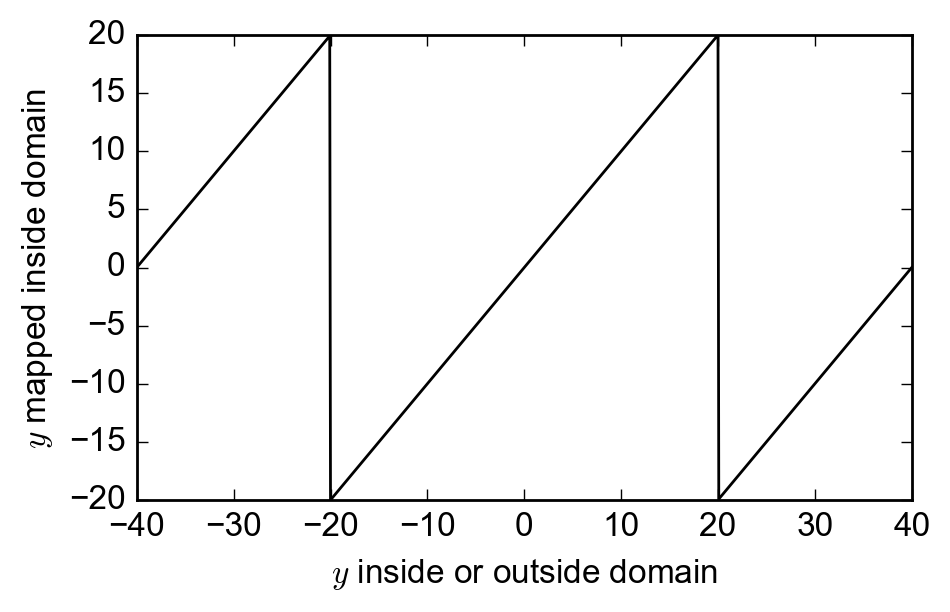

In [55]:
ytest = np.linspace(-40E-6, 40E-6, 1001)

plt.figure(figsize=(5.,3.))
plt.plot(ytest*1E6, EP.map_y_into_domain(ytest)*1E6, '-k')
plt.xlabel("$y$ inside or outside domain")
plt.ylabel("$y$ mapped inside domain")

(array([0, 0, 0, 1, 1, 2]), array([7, 8, 9, 8, 9, 9]))


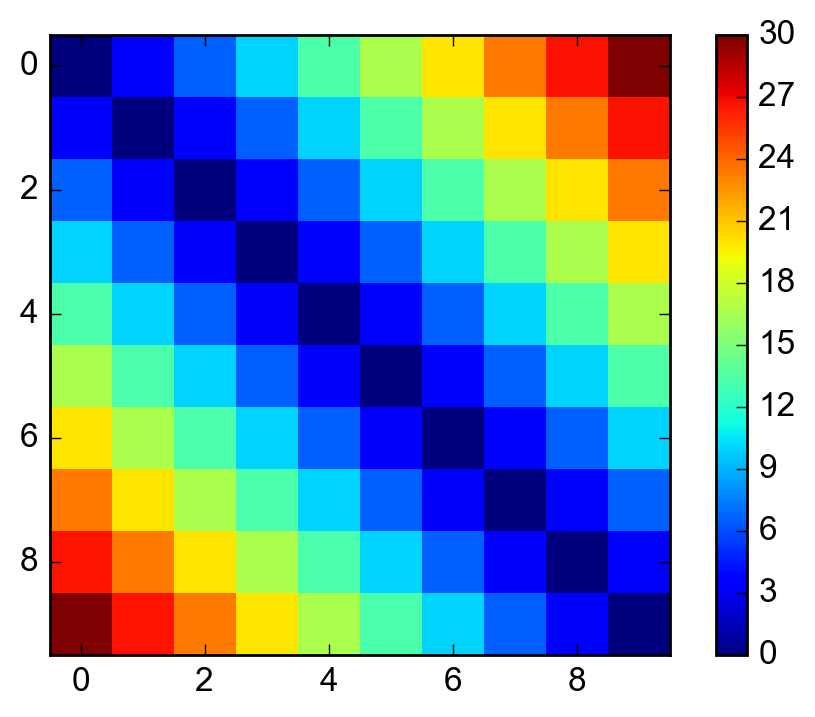

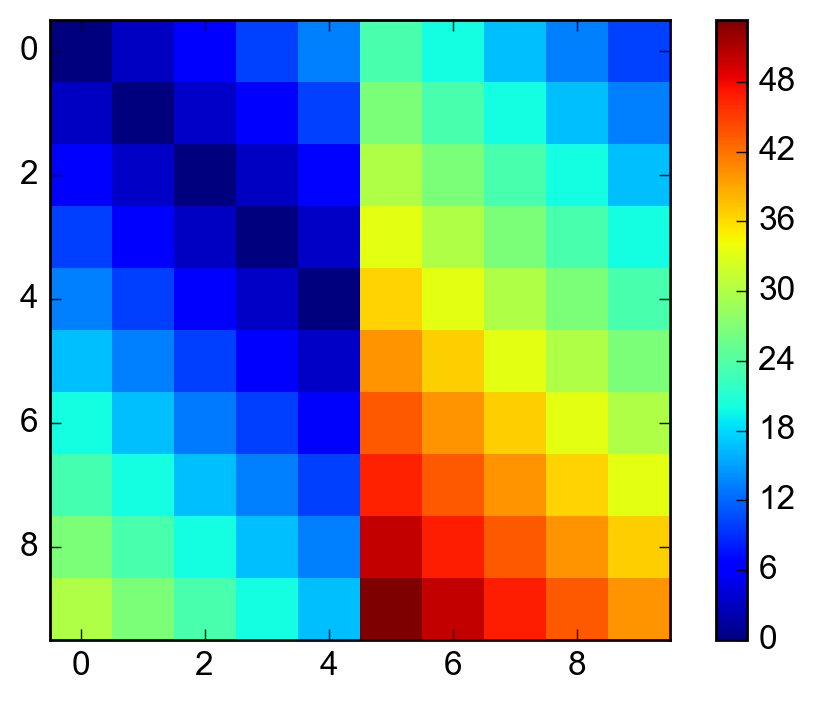

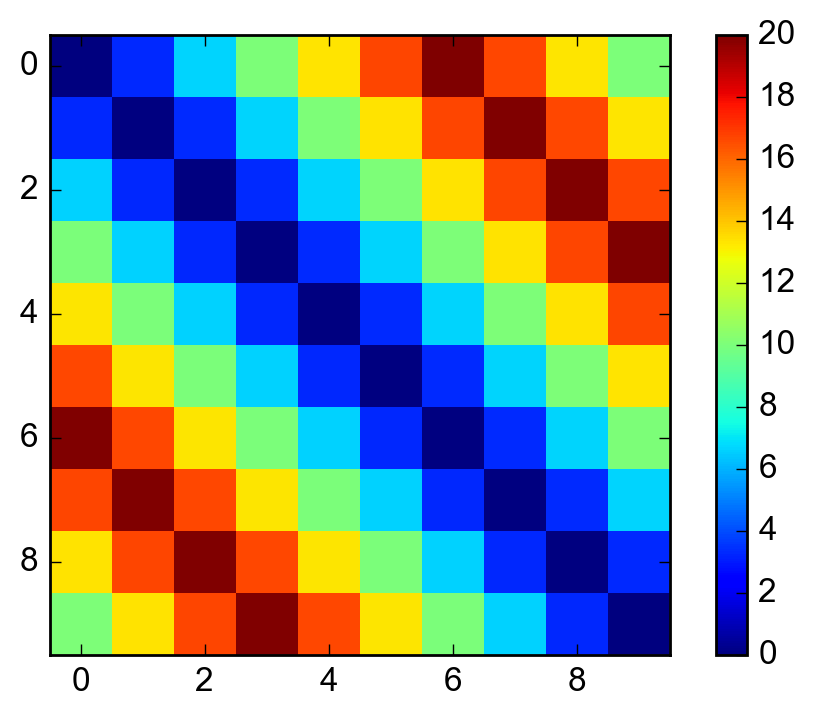

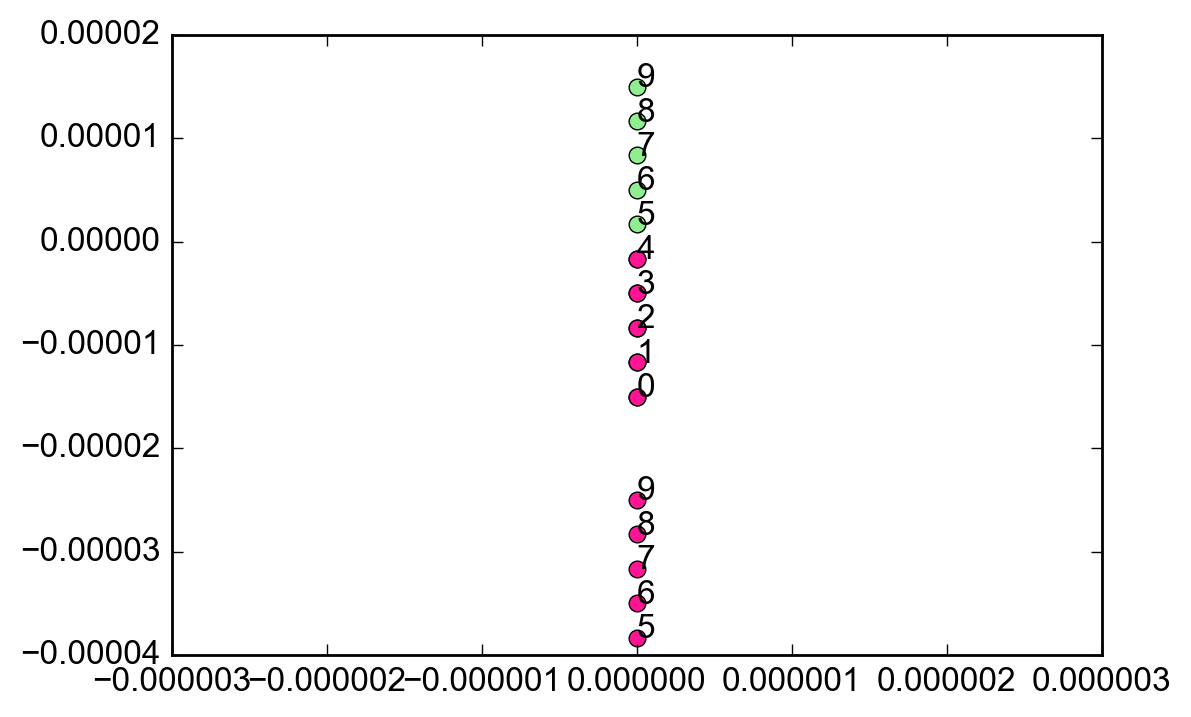

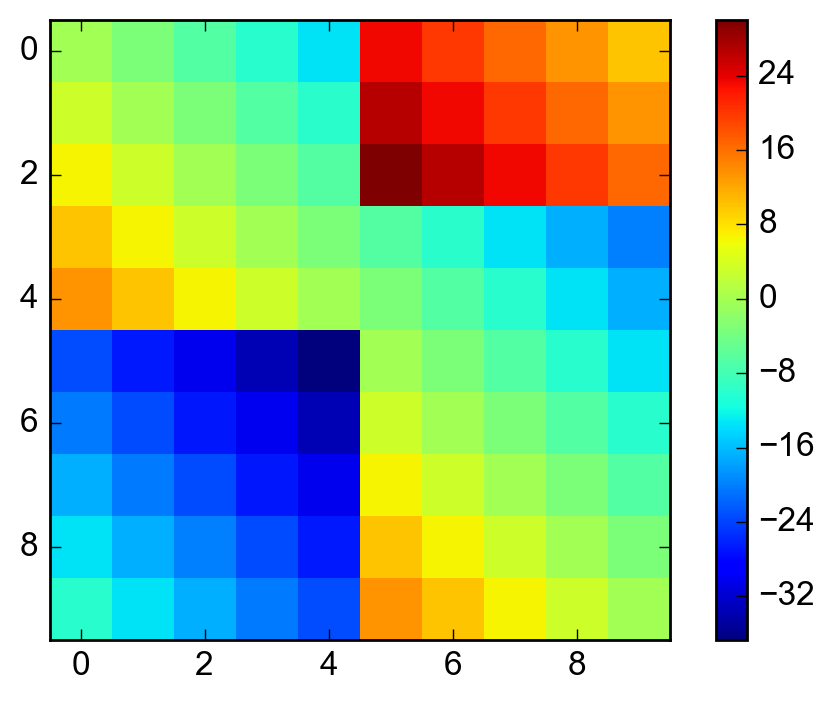

In [60]:
xe_test = np.zeros(10)
ye_test = np.linspace(-15E-6, 15E-6, 10)

ye_test_shifted = ye_test.copy()
ye_test_shifted[ye_test>0] -= 40E-6
#ye_test_shifted = EP.map_y_into_domain(ye_test_shifted)

Xe_test, Ye_test = np.meshgrid(xe_test, ye_test)
Xe_test_T, Ye_test_T = Xe_test.T, Ye_test.T


Xe_test, Ye_test_shifted = np.meshgrid(xe_test, ye_test_shifted)
Xe_test_shifted_T, Ye_test_shifted_T = Xe_test.T, Ye_test_shifted.T

Rij_conv = np.sqrt((Xe_test-Xe_test_T)**2 + (Ye_test-Ye_test_T)**2)
Rij_shifted = np.sqrt((Xe_test-Xe_test_shifted_T)**2 + (Ye_test-Ye_test_shifted_T)**2)

plt.figure()
plt.imshow(Rij_conv*1E6, interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(Rij_shifted*1E6, interpolation='none')
plt.colorbar()

plt.figure()
plt.imshow(EP.calculate_Rij(xe_test, ye_test)*1E6, interpolation='none')
plt.colorbar()

plt.figure()
plt.plot(xe_test, ye_test, 'o', color='lightgreen')
plt.plot(xe_test, ye_test_shifted, 'o', color='deeppink')
for k in range(len(xe_test)):
    plt.text(xe_test[k], ye_test[k], "%d"%k)

for k in np.where(ye_test>0)[0]:
    plt.text(xe_test[k], ye_test_shifted[k], "%d"%k)
    
plt.xlim(-3E-6, 3E-6)

print(np.where(Rij_conv>Rij_shifted))

plt.figure()
plt.imshow(EP.calculate_YiYj(xe_test, ye_test)*1E6, interpolation='none')
plt.colorbar()

In [50]:
N_electrons = 150

if 1: 
    # Rectangle
    N_cols = 30
    N_rows = 5
    if N_cols*N_rows != N_electrons:
        raise ValueError("N_cols and N_rows are not compatible with N_electrons")
    else:
        separation = 400E-9
        y0 = 0E-6
        ys = np.linspace(y0, y0+N_cols*separation, N_cols)
        yinit = np.tile(np.array(ys), N_rows)
        xs = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
        xinit = np.repeat(xs, N_cols)
if 0: 
    # Semi-circle
    initial_radius = 2.0E-6
    xinit = xeval[-1]*1E-6 + initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
if 0: 
    # Single line parallel to y
    x0 = 1E-6
    initial_span = 3E-6   
    xinit = x0 * np.ones(N_electrons)
    yinit = np.linspace(-initial_span/2., initial_span/2., N_electrons)

electron_initial_positions = anneal.xy2r(xinit, yinit)

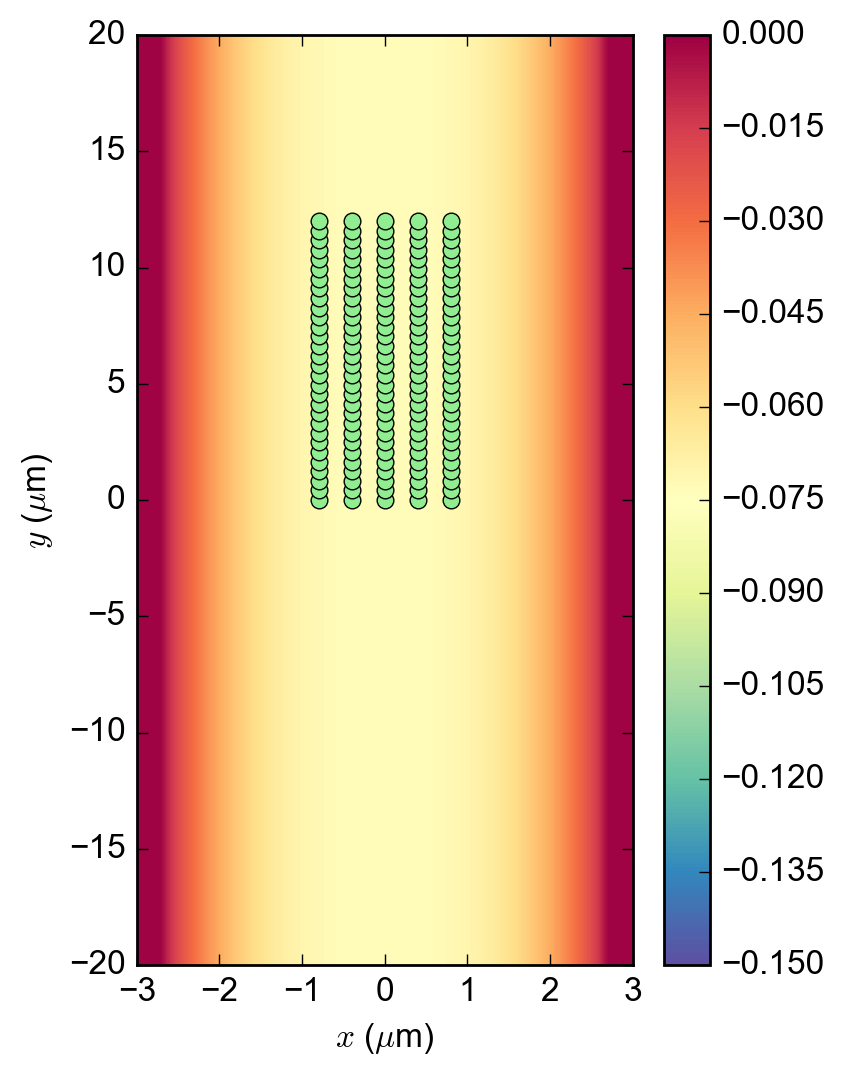

In [51]:
x_box = np.linspace(-3E-6, 3E-6, 501)
y_box = np.linspace(-20E-6, 20E-6, 21)

X_box, Y_box = np.meshgrid(x_box, y_box)

plt.figure(figsize=(4,6))
common.configure_axes(12)
plt.pcolormesh(x_box*1E6, y_box*1E6, EP.V(X_box, Y_box), cmap=plt.cm.Spectral_r, vmin=-0.15, vmax=0.00)
plt.plot(xinit*1E6, yinit*1E6, 'o', color='lightgreen')
plt.colorbar()
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

## Tests and Timing

In [ ]:
%timeit EP.Vtotal(electron_initial_positions)

In [ ]:
%timeit EP.grad_total(electron_initial_positions)

## Minimization

0	Uopt: -4.65305211 eV	Norm of gradient: 1.57e+04 eV/m
10	Uopt: -7.65612379 eV	Norm of gradient: 2.20e+05 eV/m
20	Uopt: -7.79810186 eV	Norm of gradient: 2.92e+05 eV/m
30	Uopt: -7.81545359 eV	Norm of gradient: 2.97e+05 eV/m
40	Uopt: -7.81656012 eV	Norm of gradient: 2.90e+05 eV/m
50	Uopt: -7.81676905 eV	Norm of gradient: 2.92e+05 eV/m
60	Uopt: -7.81686805 eV	Norm of gradient: 2.92e+05 eV/m
70	Uopt: -7.81704347 eV	Norm of gradient: 2.97e+05 eV/m
80	Uopt: -7.81706739 eV	Norm of gradient: 3.02e+05 eV/m
90	Uopt: -7.81707483 eV	Norm of gradient: 3.06e+05 eV/m
100	Uopt: -7.81707794 eV	Norm of gradient: 3.10e+05 eV/m
110	Uopt: -7.81708111 eV	Norm of gradient: 3.13e+05 eV/m
120	Uopt: -7.81708261 eV	Norm of gradient: 3.15e+05 eV/m
130	Uopt: -7.81708516 eV	Norm of gradient: 3.20e+05 eV/m
140	Uopt: -7.81708805 eV	Norm of gradient: 3.22e+05 eV/m
150	Uopt: -7.81709072 eV	Norm of gradient: 3.23e+05 eV/m
160	Uopt: -7.81709322 eV	Norm of gradient: 3.25e+05 eV/m
170	Uopt: -7.81709433 eV	Norm of gradient:

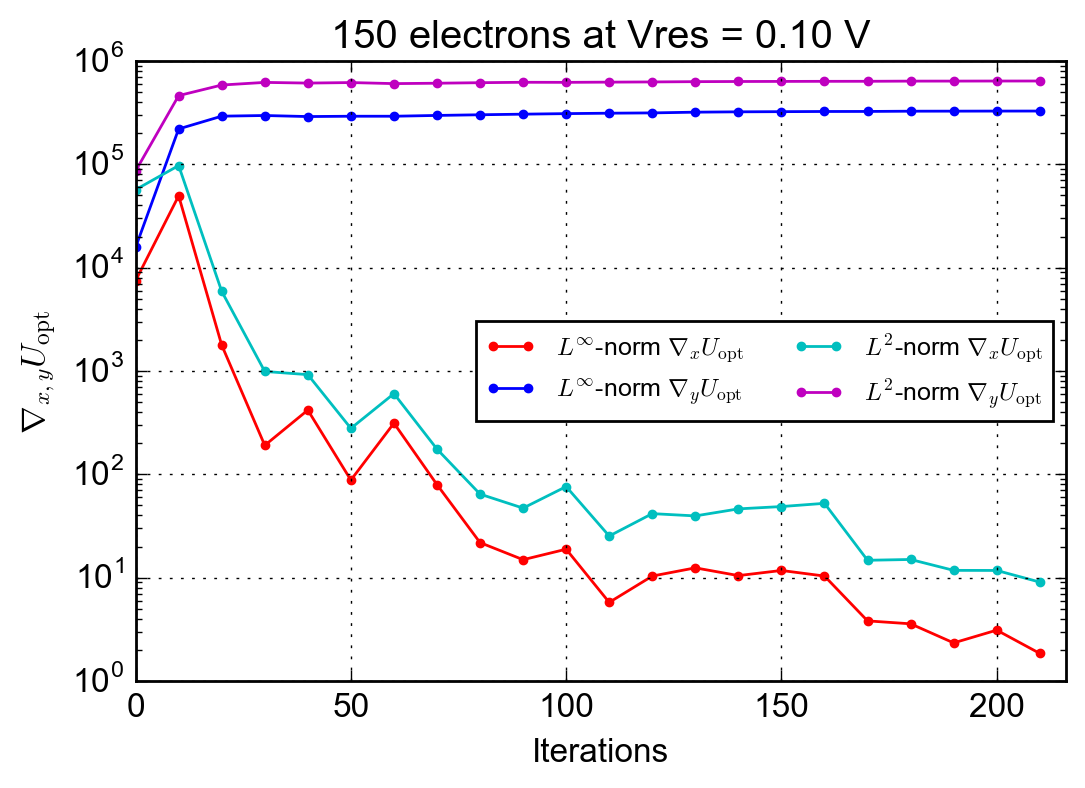

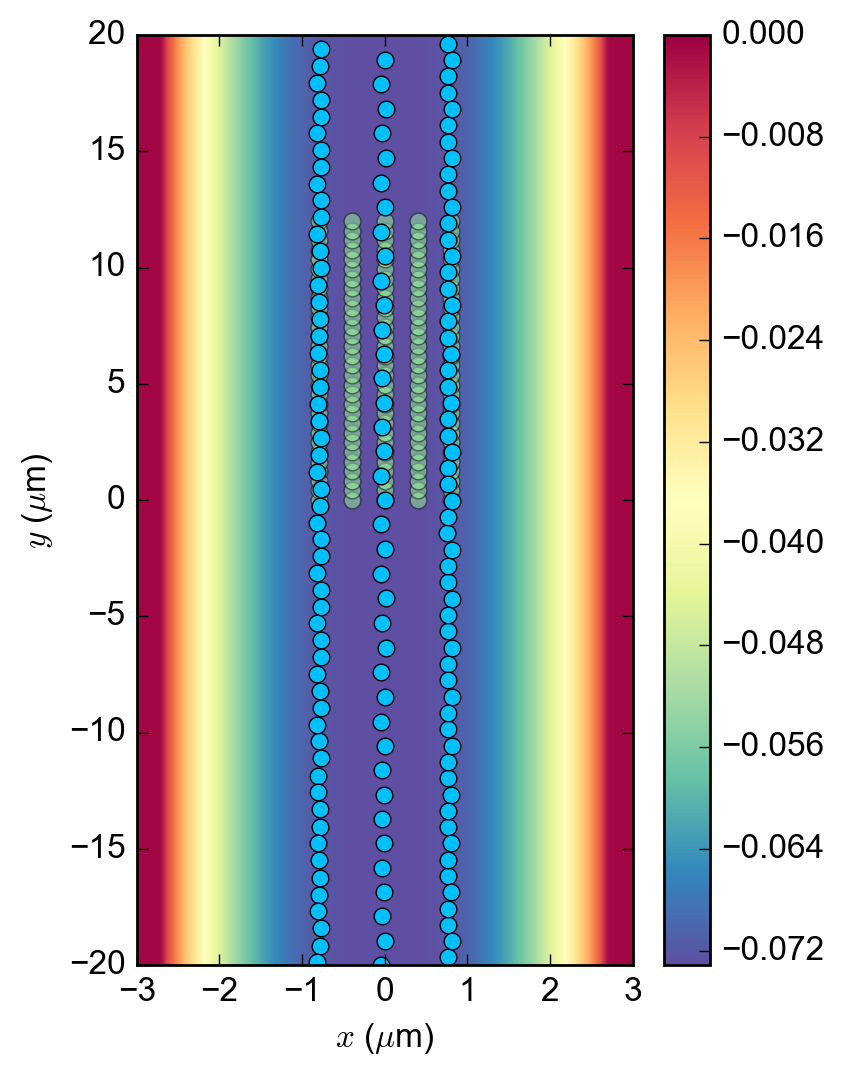

In [52]:
epsilon = 1e-10
use_gradient = False
annealing_steps = []
simulation_name = "50_electrons_anneal_4K"
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Perturbing"
sub_dir = time.strftime("%H%M%S_{}".format(simulation_name))
save = False
num_trapped_electrons = list()

if save: 
    os.mkdir(os.path.join(save_path, sub_dir))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
    os.mkdir(os.path.join(save_path, sub_dir, "Movie"))
    os.mkdir(os.path.join(save_path, sub_dir, "Data"))

conv_mon_save_path = os.path.join(save_path, sub_dir, "Figures")

ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=10, 
                                    Uext=EP.V, 
                                    xext=x_box, yext=y_box, verbose=True, eps=epsilon, 
                                    save_path=conv_mon_save_path)

if use_gradient: 
    jac=EP.grad_total
else:
    jac = None

res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
               jac=jac, 
               options={'disp': True, 'gtol' : 1E2, 'eps' : epsilon}, 
               callback=ConvMon.monitor_convergence)

x, y = anneal.r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']

%matplotlib inline
if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

y_in_domain = EP.map_y_into_domain(y)

figgy = plt.figure(figsize=(4,6))
common.configure_axes(12)
plt.pcolormesh(x_box*1E6, y_box*1E6, EP.V(X_box, Y_box), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.plot(x*1E6, y_in_domain*1E6, 'o', color='deepskyblue', alpha=1.0)
#plt.xlim(np.min(x_box*1E6), np.max(x_box*1E6))
#plt.ylim(np.min(y_box*1E6), np.max(y_box*1E6))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()